In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from textblob import TextBlob
import matplotlib.pyplot as plt
# Download NLTK resources
#nltk.download('punkt')
#nltk.download('stopwords')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
import keras_tuner as kt
#from transformers import BertTokenizer, TFBertModel
from transformers import DistilBertTokenizer, TFDistilBertModel
import tensorflow as tf
# Assume reviews.csv columns: UserID, MovieID, ReviewText, Rating

In [3]:
import pandas as pd
from sqlalchemy import create_engine

# Define your PostgreSQL connection parameters
db_user = 'postgres'
db_password = 'admin'
db_host = 'localhost'
db_port = '5433'
db_name = 'postgres'

# Create a SQLAlchemy engine to connect to the PostgreSQL database
engine = create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')




In [6]:
# Define your SQL query. You can modify this query to filter rows as needed.
query = """
SELECT *
FROM playstore_game_reviews
LIMIT 100000;  -- adjust this limit based on your memory and needs
"""

# Read the query results into a DataFrame
df = pd.read_sql(query, engine)

print("Subset of data loaded into DataFrame:")
print(df.head())


Subset of data loaded into DataFrame:
      title                                        description  \
0  Cytus II  "Cytus II" is a music rhythm game created by R...   
1  Cytus II  "Cytus II" is a music rhythm game created by R...   
2  Cytus II  "Cytus II" is a music rhythm game created by R...   
3  Cytus II  "Cytus II" is a music rhythm game created by R...   
4  Cytus II  "Cytus II" is a music rhythm game created by R...   

            summary  minInstalls  genre     genreId              appId  \
0  Can you hear me?      1000000  Music  GAME_MUSIC  com.rayark.cytus2   
1  Can you hear me?      1000000  Music  GAME_MUSIC  com.rayark.cytus2   
2  Can you hear me?      1000000  Music  GAME_MUSIC  com.rayark.cytus2   
3  Can you hear me?      1000000  Music  GAME_MUSIC  com.rayark.cytus2   
4  Can you hear me?      1000000  Music  GAME_MUSIC  com.rayark.cytus2   

                                            reviewId              userName  \
0  gp:AOqpTOEWYApxLc5LN4Ib39iESNWeUn7BRwyE

In [8]:
df.head()

,title,description,summary,minInstalls,genre,genreId,appId,reviewId,userName,content,score
0,Cytus II,"""Cytus II"" is a music rhythm game created by R...",Can you hear me?,1000000,Music,GAME_MUSIC,com.rayark.cytus2,gp:AOqpTOEWYApxLc5LN4Ib39iESNWeUn7BRwyEfxONF5g...,Vince Tugas,Definitely still good but please fix FPS issue...,3
1,Cytus II,"""Cytus II"" is a music rhythm game created by R...",Can you hear me?,1000000,Music,GAME_MUSIC,com.rayark.cytus2,gp:AOqpTOGXCPxoKNp4pGkT0Lulo22tzch6lJKxlxLqIpb...,chris ordonez,Without a doubt my favorite game. When I can a...,3
2,Cytus II,"""Cytus II"" is a music rhythm game created by R...",Can you hear me?,1000000,Music,GAME_MUSIC,com.rayark.cytus2,gp:AOqpTOFiCmtiS6z1GVviQxKrHI6iBGYu0YkBNSEx2FV...,Samuel Ericson Aguda,I downloaded this before everything was fine a...,3
3,Cytus II,"""Cytus II"" is a music rhythm game created by R...",Can you hear me?,1000000,Music,GAME_MUSIC,com.rayark.cytus2,gp:AOqpTOHOrV125WC4Yxg5A6Mcm4dH44POKmX3TA3xX0D...,Mint Tea,"Solid story, paywalls are eh, but the game see...",3
4,Cytus II,"""Cytus II"" is a music rhythm game created by R...",Can you hear me?,1000000,Music,GAME_MUSIC,com.rayark.cytus2,gp:AOqpTOH7sp3tJ9sWcPdJYCj7YDrw4HqYOgbXgNs_sc3...,Arcturian Awakened,"it has an amazing start. However, I feel like ...",3


In [10]:
df.describe()

,minInstalls,score
count,100000.000000,100000.000000
mean,615468.530000,3.539210
std,395274.229525,1.479143
min,1000.000000,1.000000
25%,100000.000000,2.000000
50%,500000.000000,4.000000
75%,1000000.000000,5.000000
max,1000000.000000,5.000000


In [12]:
df.head()

,title,description,summary,minInstalls,genre,genreId,appId,reviewId,userName,content,score
0,Cytus II,"""Cytus II"" is a music rhythm game created by R...",Can you hear me?,1000000,Music,GAME_MUSIC,com.rayark.cytus2,gp:AOqpTOEWYApxLc5LN4Ib39iESNWeUn7BRwyEfxONF5g...,Vince Tugas,Definitely still good but please fix FPS issue...,3
1,Cytus II,"""Cytus II"" is a music rhythm game created by R...",Can you hear me?,1000000,Music,GAME_MUSIC,com.rayark.cytus2,gp:AOqpTOGXCPxoKNp4pGkT0Lulo22tzch6lJKxlxLqIpb...,chris ordonez,Without a doubt my favorite game. When I can a...,3
2,Cytus II,"""Cytus II"" is a music rhythm game created by R...",Can you hear me?,1000000,Music,GAME_MUSIC,com.rayark.cytus2,gp:AOqpTOFiCmtiS6z1GVviQxKrHI6iBGYu0YkBNSEx2FV...,Samuel Ericson Aguda,I downloaded this before everything was fine a...,3
3,Cytus II,"""Cytus II"" is a music rhythm game created by R...",Can you hear me?,1000000,Music,GAME_MUSIC,com.rayark.cytus2,gp:AOqpTOHOrV125WC4Yxg5A6Mcm4dH44POKmX3TA3xX0D...,Mint Tea,"Solid story, paywalls are eh, but the game see...",3
4,Cytus II,"""Cytus II"" is a music rhythm game created by R...",Can you hear me?,1000000,Music,GAME_MUSIC,com.rayark.cytus2,gp:AOqpTOH7sp3tJ9sWcPdJYCj7YDrw4HqYOgbXgNs_sc3...,Arcturian Awakened,"it has an amazing start. However, I feel like ...",3


In [14]:
# Standard English stopwords
standard_stopwords = set(stopwords.words('english'))

# Domain-specific stopwords for movie reviews (extend as needed)
domain_stopwords = {"game", "app", "play", "install","downloads"}

# Combined stopwords
all_stopwords = standard_stopwords.union(domain_stopwords)

# Initialize lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_review(text, method='lemmatization', do_spell_correction=True, min_words=3):
    """
    Clean and normalize text reviews.
    
    Parameters:
      - text: the input review text.
      - method: choose between 'lemmatization' or 'stemming'.
      - do_spell_correction: if True, apply spell correction using TextBlob.
      - min_words: minimum number of words required; otherwise, return empty string.
    
    Returns:
      Cleaned text.
    """
    # Handle missing or non-string values
    if not isinstance(text, str):
        return ""
    
    # Remove HTML tags if any
    text = re.sub(r'<[^>]+>', ' ', text)
    
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', ' ', text).lower()
    
    # Optionally perform spell correction (Note: can be slow on large datasets)
    #if do_spell_correction:
     #   try:
     #       text = str(TextBlob(text).correct())
     #   except Exception as e:
     #       # In case spell correction fails, use the original text.
     #       pass
    
    # Tokenize text
    tokens = text.split()
    
    # Filter out tokens that are in our stopwords list
    tokens = [word for word in tokens if word not in all_stopwords]
    
    # Ensure the review has a minimum number of words; otherwise, mark as empty.
    if len(tokens) < min_words:
        return ""
    
    # Apply stemming or lemmatization as desired
    if method == 'stemming':
        tokens = [stemmer.stem(word) for word in tokens]
    else:  # default is lemmatization
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return " ".join(tokens)

# Example usage on your DataFrame:
# Replace 'text' with the appropriate column name in your dataset
df['cleaned_review'] = df['content'].apply(clean_review)
df.head()

,title,description,summary,minInstalls,genre,genreId,appId,reviewId,userName,content,score,cleaned_review
0,Cytus II,"""Cytus II"" is a music rhythm game created by R...",Can you hear me?,1000000,Music,GAME_MUSIC,com.rayark.cytus2,gp:AOqpTOEWYApxLc5LN4Ib39iESNWeUn7BRwyEfxONF5g...,Vince Tugas,Definitely still good but please fix FPS issue...,3,definitely still good please fix fps issue old...
1,Cytus II,"""Cytus II"" is a music rhythm game created by R...",Can you hear me?,1000000,Music,GAME_MUSIC,com.rayark.cytus2,gp:AOqpTOGXCPxoKNp4pGkT0Lulo22tzch6lJKxlxLqIpb...,chris ordonez,Without a doubt my favorite game. When I can a...,3,without doubt favorite actually get start scre...
2,Cytus II,"""Cytus II"" is a music rhythm game created by R...",Can you hear me?,1000000,Music,GAME_MUSIC,com.rayark.cytus2,gp:AOqpTOFiCmtiS6z1GVviQxKrHI6iBGYu0YkBNSEx2FV...,Samuel Ericson Aguda,I downloaded this before everything was fine a...,3,downloaded everything fine downloaded im stuck...
3,Cytus II,"""Cytus II"" is a music rhythm game created by R...",Can you hear me?,1000000,Music,GAME_MUSIC,com.rayark.cytus2,gp:AOqpTOHOrV125WC4Yxg5A6Mcm4dH44POKmX3TA3xX0D...,Mint Tea,"Solid story, paywalls are eh, but the game see...",3,solid story paywalls eh seems poorly optimised...
4,Cytus II,"""Cytus II"" is a music rhythm game created by R...",Can you hear me?,1000000,Music,GAME_MUSIC,com.rayark.cytus2,gp:AOqpTOH7sp3tJ9sWcPdJYCj7YDrw4HqYOgbXgNs_sc3...,Arcturian Awakened,"it has an amazing start. However, I feel like ...",3,amazing start however feel like available inst...


In [16]:
sid = SentimentIntensityAnalyzer()

def get_sentiment_rating(text):
    sentiment = sid.polarity_scores(text)
    # VADER compound score is in [-1, 1]. We'll map it to a 1-5 scale.
    compound = sentiment['compound']
    rating = np.interp(compound, [-1, 1], [1, 5])
    return rating

In [18]:
if 'rating' not in df.columns or df['rating'].isnull().any():
    df['inferred_rating'] = df['cleaned_review'].apply(get_sentiment_rating)
    df['rating'] = df['inferred_rating']
    


In [20]:
df.head(10)

,title,description,summary,minInstalls,genre,genreId,appId,reviewId,userName,content,score,cleaned_review,inferred_rating,rating
0,Cytus II,"""Cytus II"" is a music rhythm game created by R...",Can you hear me?,1000000,Music,GAME_MUSIC,com.rayark.cytus2,gp:AOqpTOEWYApxLc5LN4Ib39iESNWeUn7BRwyEfxONF5g...,Vince Tugas,Definitely still good but please fix FPS issue...,3,definitely still good please fix fps issue old...,4.7250,4.7250
1,Cytus II,"""Cytus II"" is a music rhythm game created by R...",Can you hear me?,1000000,Music,GAME_MUSIC,com.rayark.cytus2,gp:AOqpTOGXCPxoKNp4pGkT0Lulo22tzch6lJKxlxLqIpb...,chris ordonez,Without a doubt my favorite game. When I can a...,3,without doubt favorite actually get start scre...,2.8098,2.8098
2,Cytus II,"""Cytus II"" is a music rhythm game created by R...",Can you hear me?,1000000,Music,GAME_MUSIC,com.rayark.cytus2,gp:AOqpTOFiCmtiS6z1GVviQxKrHI6iBGYu0YkBNSEx2FV...,Samuel Ericson Aguda,I downloaded this before everything was fine a...,3,downloaded everything fine downloaded im stuck...,4.0212,4.0212
3,Cytus II,"""Cytus II"" is a music rhythm game created by R...",Can you hear me?,1000000,Music,GAME_MUSIC,com.rayark.cytus2,gp:AOqpTOHOrV125WC4Yxg5A6Mcm4dH44POKmX3TA3xX0D...,Mint Tea,"Solid story, paywalls are eh, but the game see...",3,solid story paywalls eh seems poorly optimised...,4.0212,4.0212
4,Cytus II,"""Cytus II"" is a music rhythm game created by R...",Can you hear me?,1000000,Music,GAME_MUSIC,com.rayark.cytus2,gp:AOqpTOH7sp3tJ9sWcPdJYCj7YDrw4HqYOgbXgNs_sc3...,Arcturian Awakened,"it has an amazing start. However, I feel like ...",3,amazing start however feel like available inst...,4.4860,4.4860
5,Cytus II,"""Cytus II"" is a music rhythm game created by R...",Can you hear me?,1000000,Music,GAME_MUSIC,com.rayark.cytus2,gp:AOqpTOH82e6ZVrDalAx_a2BsLCSAaBzlNsMOu2yIoDV...,Rinomon,I love the game but I'd adore it even more if ...,3,love adore even put rin kagamine downloaded cu...,4.8548,4.8548
6,Cytus II,"""Cytus II"" is a music rhythm game created by R...",Can you hear me?,1000000,Music,GAME_MUSIC,com.rayark.cytus2,gp:AOqpTOEsE-guLI4Xp5HU0DAwoe80hvG0UQdYUGRrNow...,portalmaster 052,This game is pretty good but you have pay for ...,3,pretty good pay dont get character song opinio...,4.3816,4.3816
7,Cytus II,"""Cytus II"" is a music rhythm game created by R...",Can you hear me?,1000000,Music,GAME_MUSIC,com.rayark.cytus2,gp:AOqpTOEhKY7FVKZwdjoI0urHNLG5qir2AkKbMDMRShj...,Omar Holmes,"Really like the game, it's just way too overpr...",3,really like way overpriced many thing buy,3.8402,3.8402
8,Cytus II,"""Cytus II"" is a music rhythm game created by R...",Can you hear me?,1000000,Music,GAME_MUSIC,com.rayark.cytus2,gp:AOqpTOHIWzn8BocjggLk_NVNQmiBO0Nzq2X2TJSJ0kp...,Kurifu Kun,The game always terminates when I open it sinc...,3,always terminates open since update detects ki...,4.6346,4.6346
9,Cytus II,"""Cytus II"" is a music rhythm game created by R...",Can you hear me?,1000000,Music,GAME_MUSIC,com.rayark.cytus2,gp:AOqpTOFzo98wKO4EQCZdHQOtJY8Ea6Le5IMaRYGozi1...,Steven Muñoz Toapanta,"Some songs on ""hard"" difficulty are still extr...",3,song hard difficulty still extremely slow noti...,2.1570,2.1570


In [24]:


# Encode user and app IDs based on the new dataset's column names
user_ids = df['userName'].unique().tolist()  # Unique user names
app_ids = df['appId'].unique().tolist()  # Unique app IDs

# Create mappings from user and app IDs to numeric indices
user2idx = {user: idx for idx, user in enumerate(user_ids)}
app2idx = {app: idx for idx, app in enumerate(app_ids)}

# Apply mappings to create numerical indices
df['user_idx'] = df['userName'].map(user2idx)
df['app_idx'] = df['appId'].map(app2idx)



In [26]:


# Initialize DistilBERT tokenizer and model
distilbert_model_name = 'distilbert-base-uncased'
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(distilbert_model_name)
distilbert_encoder = TFDistilBertModel.from_pretrained(distilbert_model_name)



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [30]:
# Function to tokenize reviews using DistilBERT
def encode_reviews_for_distilbert(texts, max_length=128):
    encoding = distilbert_tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )
    return encoding['input_ids'], encoding['attention_mask']



In [34]:
# Prepare training data 
X_user = np.array(df['user_idx'].tolist())
X_app  = np.array(df['app_idx'].tolist())  
y = np.array(df['rating'].tolist())

print("User input shape:", X_user.shape)
print("App input shape:", X_app.shape)  
print("Ratings shape:", y.shape)



User input shape: (100000,)
App input shape: (100000,)
Ratings shape: (100000,)


In [36]:
# CHANGE: Instead of using your Keras Tokenizer for reviews,
# you could encode the reviews using BERT.
#X_input_ids, X_attention_mask = encode_reviews_for_bert(df['cleaned_review'], max_length=128)
X_input_ids, X_attention_mask = encode_reviews_for_distilbert(df['cleaned_review'], max_length=128)
# Convert to numpy arrays for consistency.
X_input_ids = X_input_ids.numpy()
X_attention_mask = X_attention_mask.numpy()


In [40]:
X_user_train, X_user_test, X_app_train, X_app_test, \
X_input_ids_train, X_input_ids_test, X_attention_mask_train, X_attention_mask_test, \
y_train, y_test = train_test_split(
    X_user, X_app, X_input_ids, X_attention_mask, y, test_size=0.2, random_state=42
)


In [42]:
num_users = len(user2idx)
num_apps = len(app2idx)



In [44]:
def build_transformer_model(hp):
   
    user_input = Input(shape=(1,), name='user_input')
    app_input = Input(shape=(1,), name='app_input')
    
    # DistilBERT Review Inputs 
    review_input_ids = Input(shape=(128,), dtype=tf.int32, name='review_input_ids')
    review_attention_mask = Input(shape=(128,), dtype=tf.int32, name='review_attention_mask')

    # User Embedding
    user_embedding_dim = hp.Choice('user_embedding_dim', values=[8, 10, 16])
    user_embedding = tf.keras.layers.Embedding(input_dim=len(user2idx),
                                               output_dim=user_embedding_dim,
                                               name='user_embedding')(user_input)
    user_vec = Flatten(name='user_flatten')(user_embedding)

    app_embedding_dim = hp.Choice('app_embedding_dim', values=[8, 10, 16])
    app_embedding = tf.keras.layers.Embedding(input_dim=len(app2idx),
                                              output_dim=app_embedding_dim,
                                              name='app_embedding')(app_input)
    app_vec = Flatten(name='app_flatten')(app_embedding)

    # DistilBERT Transformer Layer
    def distilbert_pooler(inputs):
        input_ids, attention_mask = inputs
        outputs = distilbert_encoder(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0, :]  # Take the CLS token representation

    
    review_vec = tf.keras.layers.Lambda(distilbert_pooler, output_shape=(768,), name='distilbert_pooler')([review_input_ids, review_attention_mask])

    # Concatenate all features: user, app, and review embeddings
    concat = Concatenate(name='concatenate')([user_vec, app_vec, review_vec])

    # Dense layers
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    dense1 = Dense(dense_units, activation='relu', name='dense1')(concat)
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    dropout_layer = Dropout(dropout_rate, name='dropout')(dense1)

    dense2 = Dense(dense_units // 2, activation='relu', name='dense2')(dropout_layer)
    output = Dense(1, activation='linear', name='rating_prediction')(dense2)

    # Build model with updated inputs (user_input, app_input, review_input_ids, review_attention_mask)
    model = Model(inputs=[user_input, app_input, review_input_ids, review_attention_mask], outputs=output)

    # Learning rate tuning
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-4, sampling='log')
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

    return model


In [46]:

# Set up a RandomSearch tuner for DistilBERT using the new app-related variables
distilbert_tuner = kt.RandomSearch(
    build_transformer_model,
    objective='val_loss',
    max_trials=10,  # You can reduce this for quick testing
    directory='distilbert_tuner_playstore_app_dir',
    project_name='distilbert_app_reviews'
)

# Run the hyperparameter search
distilbert_tuner.search(
    [X_user_train, X_app_train, X_input_ids_train, X_attention_mask_train], 
    y_train,
    validation_split=0.1,
    epochs=5,  # Adjust epochs during tuning as needed
    batch_size=64
)




Trial 10 Complete [08h 31m 37s]
val_loss: 0.8081936240196228

Best val_loss So Far: 0.3409833610057831
Total elapsed time: 3d 22h 13m 40s


In [50]:

# Train the best DistilBERT model
best_distilbert_hps = distilbert_tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters for transformer model:")
print(f"User Embedding Dim: {best_distilbert_hps.get('user_embedding_dim')}")
print(f"App Embedding Dim: {best_distilbert_hps.get('app_embedding_dim')}")
print(f"Dense Units: {best_distilbert_hps.get('dense_units')}")
print(f"Dropout Rate: {best_distilbert_hps.get('dropout_rate')}")
print(f"Learning Rate: {best_distilbert_hps.get('learning_rate')}")

best_distilbert_model = distilbert_tuner.hypermodel.build(best_distilbert_hps)
history_distilbert = best_distilbert_model.fit(
    [X_user_train, X_app_train, X_input_ids_train, X_attention_mask_train],  
    y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=64
)


Best hyperparameters for transformer model:
User Embedding Dim: 16
App Embedding Dim: 8
Dense Units: 128
Dropout Rate: 0.0
Learning Rate: 1.5347180356242464e-05
Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6118s 5s/step - loss: 5.2359 - mae: 1.7929 - val_loss: 0.5369 - val_mae: 0.5298
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6114s 5s/step - loss: 0.5015 - mae: 0.5073 - val_loss: 0.4213 - val_mae: 0.4541
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6074s 5s/step - loss: 0.3941 - mae: 0.4434 - val_loss: 0.3756 - val_mae: 0.4297
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6117s 5s/step - loss: 0.3740 - mae: 0.4285 - val_loss: 0.3546 - val_mae: 0.4118
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6064s 5s/step - loss: 0.3515 - mae: 0.4111 - val_loss: 0.3403 - val_mae: 0.4061
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6098s 5s/step - loss: 0.3380 - mae: 0.4011 - val_loss: 0.3287 - val_mae: 0.3951
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6094s 5s/step - loss: 0.3299 - mae: 0.3947 - val_loss: 0.3205 - v

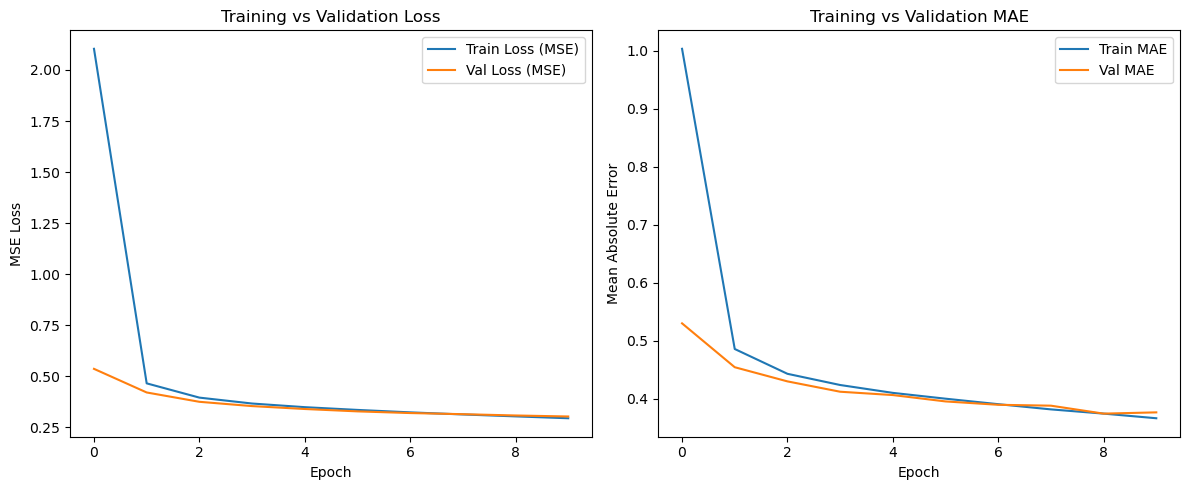

In [52]:
import matplotlib.pyplot as plt



# Plot training and validation loss and MAE
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history_distilbert.history['loss'], label='Train Loss (MSE)')
plt.plot(history_distilbert.history['val_loss'], label='Val Loss (MSE)')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# MAE plot
plt.subplot(1, 2, 2)
plt.plot(history_distilbert.history['mae'], label='Train MAE')
plt.plot(history_distilbert.history['val_mae'], label='Val MAE')
plt.title('Training vs Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()


In [54]:
# Evaluate on the test set for transformer model (using app variables)
loss_t, mae_t = best_distilbert_model.evaluate(
    [X_user_test, X_app_test, X_input_ids_test, X_attention_mask_test], y_test
)
print(f"Transformer Model Test MSE: {loss_t:.4f}, Test MAE: {mae_t:.4f}")



625/625 ━━━━━━━━━━━━━━━━━━━━ 1693s 3s/step - loss: 0.3111 - mae: 0.3794
Transformer Model Test MSE: 0.3117, Test MAE: 0.3792


In [56]:

y_pred = best_distilbert_model.predict(
    [X_user_test, X_app_test, X_input_ids_test, X_attention_mask_test]
).flatten()



625/625 ━━━━━━━━━━━━━━━━━━━━ 1715s 3s/step


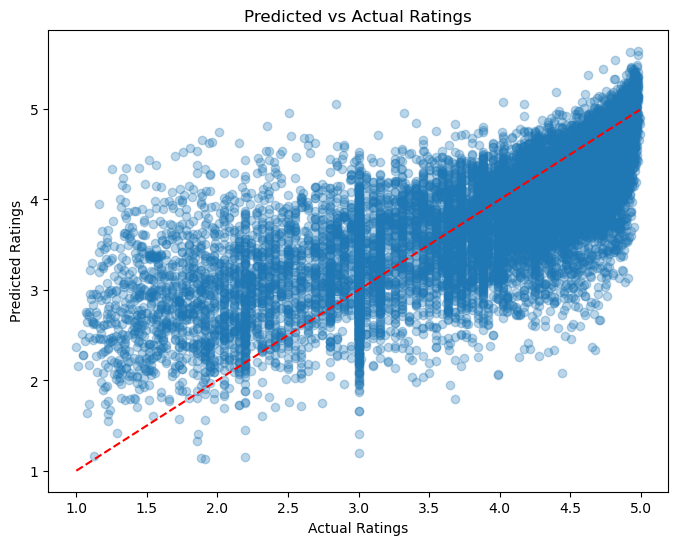

In [58]:

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Reference line
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Predicted vs Actual Ratings')
plt.show()



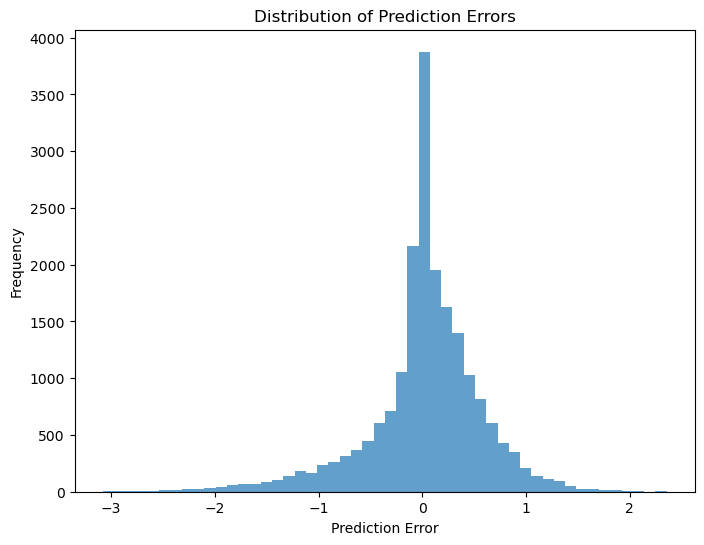

In [60]:

errors = y_test - y_pred


plt.figure(figsize=(8, 6))
plt.hist(errors, bins=50, alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()

In [62]:
import pandas as pd

# Assuming X_user_test, X_app_test, y_test, and y_pred are defined from your evaluation
test_df = pd.DataFrame({
    'user': X_user_test, 
    'app': X_app_test,  # Updated column name from movie to app
    'true_rating': y_test, 
    'predicted_rating': y_pred
})

print(test_df.head())


    user  app  true_rating  predicted_rating
0  67049   40       4.2738          3.128093
1  71119   37       3.7224          3.634051
2  17178   10       2.1962          3.673382
3  67968   40       4.5002          4.604743
4  80051   50       3.7636          4.348782


In [64]:
import numpy as np

def precision_recall_ndcg(test_df, k=10, relevance_threshold=4.0):
    """
    Computes Precision@K, Recall@K, and NDCG@K for each user and returns their averages.
    
    Parameters:
      test_df: DataFrame with columns: 'user', 'movie', 'true_rating', 'predicted_rating'
      k: the cutoff rank for evaluation
      relevance_threshold: true ratings at or above this value are considered relevant
      
    Returns:
      avg_precision, avg_recall, avg_ndcg: Average metrics across all users.
    """
    # Group the results by user
    user_groups = test_df.groupby('user')
    
    precisions = []
    recalls = []
    ndcgs = []
    
    for user, group in user_groups:
        # Sort this user's items by predicted rating in descending order
        group_sorted = group.sort_values('predicted_rating', ascending=False)
        top_k = group_sorted.head(k)
        
        # Determine which of the top-k items are relevant
        relevant = (top_k['true_rating'] >= relevance_threshold).astype(int).values
        num_relevant_in_top_k = relevant.sum()
        
        # Calculate Precision@K for this user
        precision = num_relevant_in_top_k / k
        
        # Count the total number of relevant items for this user in the test set
        total_relevant = (group['true_rating'] >= relevance_threshold).sum()
        recall = num_relevant_in_top_k / total_relevant if total_relevant > 0 else 0.0
        
        # Compute DCG@K for this user's top-k recommendations
        dcg = sum([(2**rel - 1) / np.log2(idx + 2) for idx, rel in enumerate(relevant)])
        
        # Compute Ideal DCG (IDCG) using the best possible ranking
        # Get relevance scores (1 if rating>=threshold else 0) for all items for this user,
        # sort them in descending order, and take the top-k.
        ideal_relevances = group['true_rating'].apply(lambda x: 1 if x >= relevance_threshold else 0)
        ideal_sorted = ideal_relevances.sort_values(ascending=False).head(k).values
        idcg = sum([(2**rel - 1) / np.log2(idx + 2) for idx, rel in enumerate(ideal_sorted)])
        
        ndcg = dcg / idcg if idcg > 0 else 0.0
        
        precisions.append(precision)
        recalls.append(recall)
        ndcgs.append(ndcg)
    
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_ndcg = np.mean(ndcgs)
    
    return avg_precision, avg_recall, avg_ndcg


In [66]:
# Assume you have already generated predictions (y_pred) and created test_df
# Set k (e.g., 10) and a relevance threshold (e.g., 4.0)
k = 10
relevance_threshold = 4.0

avg_precision, avg_recall, avg_ndcg = precision_recall_ndcg(test_df, k=k, relevance_threshold=relevance_threshold)

print(f"Precision@{k}: {avg_precision:.4f}")
print(f"Recall@{k}: {avg_recall:.4f}")
print(f"NDCG@{k}: {avg_ndcg:.4f}")


Precision@10: 0.0515
Recall@10: 0.5040
NDCG@10: 0.5039


In [70]:
# Mapping app IDs to titles
app_id_to_title = df[['appId', 'title']].drop_duplicates().set_index('appId')['title'].to_dict()


In [72]:
# Example: Predict ratings for a sample user for all apps.
sample_user = 7
all_app_indices = np.array(list(range(num_apps)))  # Changed from num_movies to num_apps
sample_user_input = np.full(shape=(num_apps,), fill_value=sample_user)

# For review inputs, you need to provide tokenized data. 
# Here we use a placeholder sequence (e.g., an empty review) for each app.
empty_reviews = pd.Series([""] * num_apps)
default_input_ids, default_attention_mask = encode_reviews_for_distilbert(empty_reviews, max_length=128)
default_input_ids = default_input_ids.numpy()
default_attention_mask = default_attention_mask.numpy()

# Predict ratings using the best DistilBERT model
predicted_ratings_transformer = best_distilbert_model.predict(
    [sample_user_input, all_app_indices, default_input_ids, default_attention_mask]
).flatten()

# Get the top 10 recommended app indices and then map them to app titles
recommended_app_indices_transformer = np.argsort(predicted_ratings_transformer)[::-1][:10]
recommended_app_titles = [app_id_to_title[app_ids[i]] for i in recommended_app_indices_transformer]

print("Top recommended app titles for user", sample_user, "using transformer model:")
for title in recommended_app_titles:
    print(title)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Top recommended app titles for user 7 using transformer model:
Monument Valley 2
Monument Valley
Pocket City
Motorsport Manager Mobile 3
The Room Two
The Room Three
Motorsport Manager Mobile 2
Lara Croft GO
Cytus II
Bridge Constructor Portal
